In [19]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import io
import scipy.io as sio
%matplotlib inline 
import pylab
import csv
from Tkinter import Tk
from tkFileDialog import askopenfilename
from tkFileDialog import askdirectory
import nibabel as nb
from scipy import io
#from nifti import NiftiImage
import nibabel as nb
from scipy.interpolate import interp1d
from scipy import ndimage

# Open data

In [20]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/UVvsBlue/985/985ss1_500Ukf260Smith0_4_60TS.mat


In [21]:
Ua=sio.loadmat(filename)
DT=Ua['TSo']
DT.shape

(9053, 260)

In [22]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename2 = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename2)

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/UVvsBlue/985/985ss1_500Ukf260Smith0_4_60IC.nii


In [23]:
img1 = nb.load(filename2)
data = img1.get_data()
S=data.shape
S

(105, 50, 40, 260)

In [24]:
S=data.shape
S

(105, 50, 40, 260)

Z-score

In [25]:
Demean=np.zeros(S)
Dmaps=np.zeros(S)
Dvar=np.zeros(S)
Var=np.zeros(S[3])
D2=np.zeros([S[0],S[1],5,S[3]])
Tvar=np.zeros(S[3])

In [26]:
for i in range(S[3]):
    Demean[:,:,:,i]=data[:,:,:,i]-np.mean(np.mean(np.mean(data[:,:,:,i],0),0),0)

In [27]:
for i in range(S[3]):
    Dsq=np.reshape(Demean[:,:,:,i],S[0]*S[1]*S[2])
    Var[i]=np.sqrt(np.var(Dsq))
    Dvar=Demean[:,:,:,i]/Var[i]
    Dmaps[:,:,:,i]=Dvar-2.5
    Tvar[i]=np.var(DT[i,:])
Dmaps[Dmaps<0]=0

# Open Masks

In [28]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filenameM = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filenameM)
img1 = nb.load(filenameM)
Masks = img1.get_data()
Sm=Masks.shape
Masks=np.array(Masks)

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/UVvsBlue/985/985Registration/JFRC985TransformedseparateLargetrimmed.nii


In [29]:
filenameM='/home/sophie/LargeRegionList'
with open(filenameM) as f:
    content = f.readlines()
Names=[Line.replace('\n','').split(' ') for Line in content]
RegionName=[Names[i][1] for i in range(12)]
Num=[int(Names[i][0]) for i in range(12)]

In [30]:
RegionName

['OL',
 'VLNP',
 'VMNP',
 'AL',
 'MB',
 'LH',
 'SNP',
 'CX',
 'LX',
 'INP',
 'PENP',
 'GNG']

# Average in masks to sort components by brain region

In [31]:
Dmaps.shape

(105, 50, 40, 260)

In [32]:
M=np.zeros((S[3],13))
Mapmean=np.zeros(S[3])
MMasks=np.zeros(13)

In [33]:
for i in range(S[3]):
    Mapmean[i]=np.mean(np.mean(np.mean(Dmaps[:,:,:,i])))
    for j in range(12):
        MMasks[j]=np.mean(np.mean(np.mean(Masks[:,:,:,j])))
        if MMasks[j]:
            M[i,j]=np.mean(np.mean(np.mean(Masks[:,:,:,j]*Dmaps[:,:,:,i])))/(MMasks[j]*Mapmean[i])

In [34]:
CompMainName=S[3]*['']
CompNameAdd=np.zeros((S[3],12))
for i in range(S[3]):
    Max=np.max(M[i,:])
    I=np.argmax(M[i,:])+1
    for j in range(12):
        J=[l for l in range(12) if Num[l]==(j+1)]
        if M[i,j]>0.2*Max:
            CompNameAdd[i,J]=1
    J=[l for l in range(12) if Num[l]==I]
    if J!= []:
        CompMainName[i]=Names[np.array(J)][0]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [35]:
J

[7]

OL


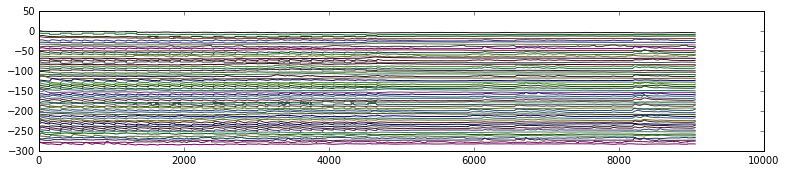

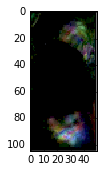

VLNP


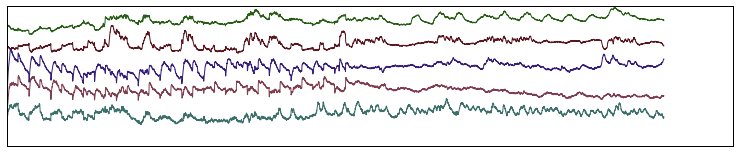

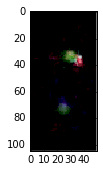

VMNP


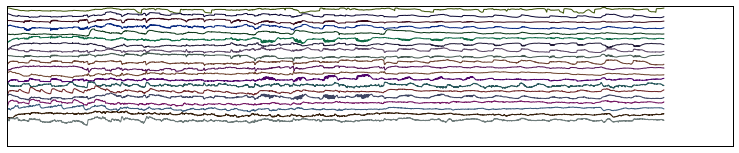

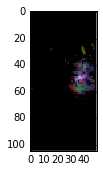

AL


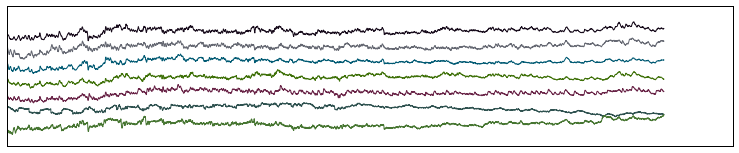

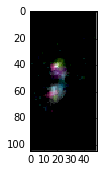

MB


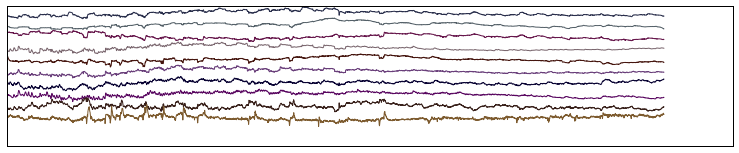

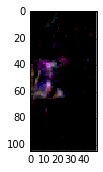

LH


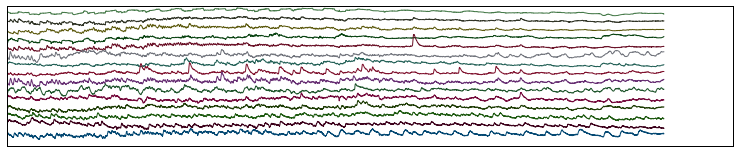

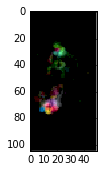

SNP


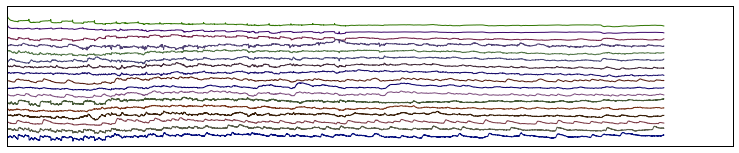

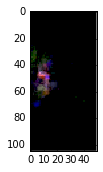

CX


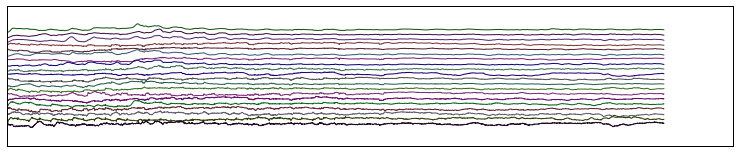

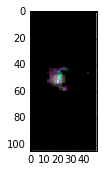

INP


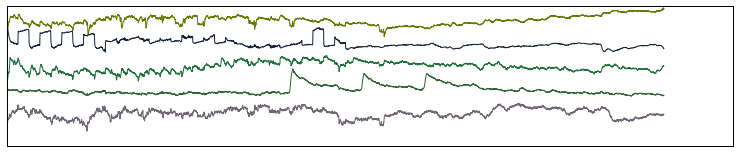

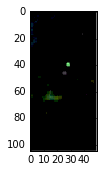

PENP


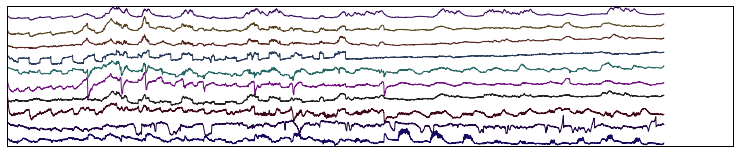

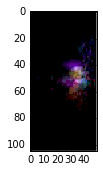

GNG


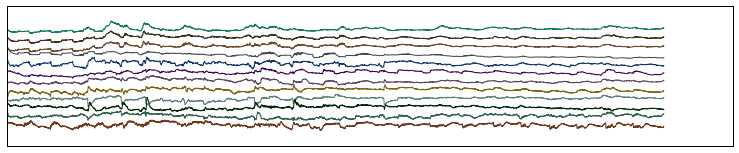

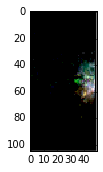

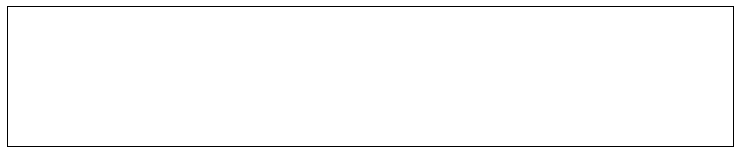

In [36]:
pylab.rcParams['figure.figsize'] = (13, 2.5)

h=5
tot=0
GoodICAnat=np.zeros(S[3])

for l in range(12):
    Final_maps=np.zeros((S[0],S[1],3))
    Fmap=np.zeros((S[0],S[1],3))
    C=np.zeros(3)

    n=0
    for i in range(len(CompMainName)):                    
        Dmmv=np.mean(data[:,:,:,i],2) 
        Dmmv[Dmmv<0.2*np.max(np.max(np.max(Dmmv)))]=0
        C=np.squeeze(np.random.rand(3,1))
        labeled, nrobject=ndimage.label(Dmmv>0)
        
        if CompMainName[i]==Names[l][0] and (sum(CompNameAdd[i,:])<5) and nrobject<200:
            n=n+1            
            
            for k in range(3):
                Fmap[:,:,k]=0.7*Dmmv*C[k]/np.max(C)
            Final_maps=Final_maps+Fmap
            #plt.plot(Time_fluoICA.T,(DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            plt.plot((DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            tot=tot+1
            GoodICAnat[i]=1
            
                    
    if n!=0:
        print(RegionName[l])
        plt.show()
        FM=Final_maps/np.max(np.max(Final_maps))
        FM[FM<0.1]=0
        plt.imshow(FM,interpolation='none')
        plt.show()
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
        


##### Looked at the components maps and time series and remove all the components which are localized on the edge of the brain and with activity unlike GCaMP6 transients.


In [20]:
BadICs=[178,115,87,138,5,18,58,125,154,22,21,10,26,134]

In [21]:
for idx in BadICs:
    GoodICAnat[idx] = 0.0

5
6
7
13
14
16
17
21
24
27
28
31
33
36
37
38
39
41
42
44
47
49
50
55
57
65
68
71
73
74
75
76
78
79
83
84
88
89
92
95
98
100
102
104
108
126
130
133
135
138
156
161
176
191
194
204
220
OL


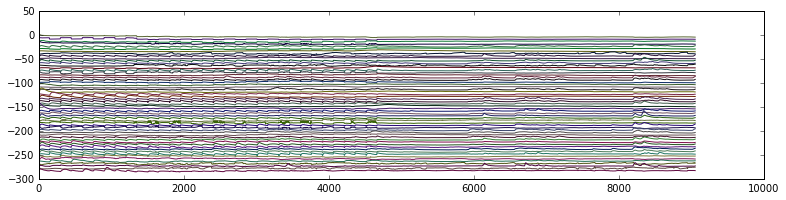

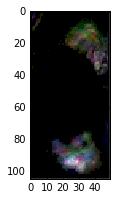

60
131
171
190
246
VLNP


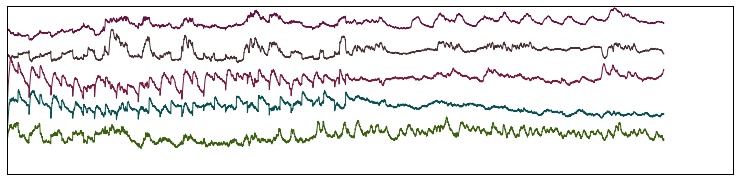

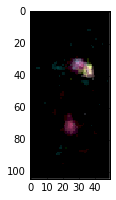

8
29
32
53
61
67
69
106
114
121
122
142
143
153
169
173
180
183
214
245
VMNP


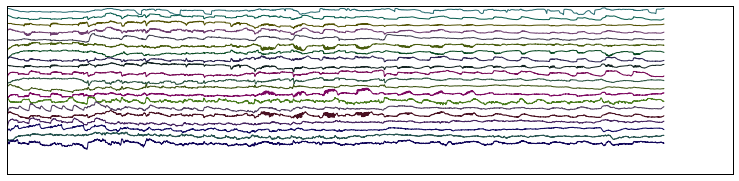

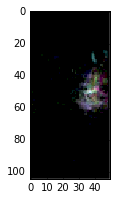

54
56
82
99
124
165
215
AL


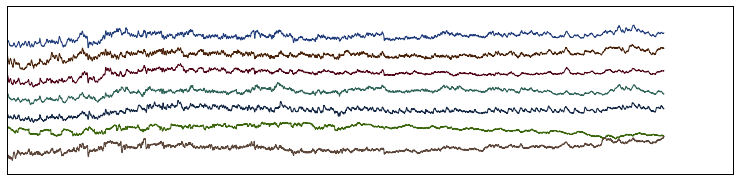

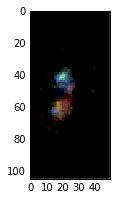

19
25
30
34
51
64
96
109
159
221
MB


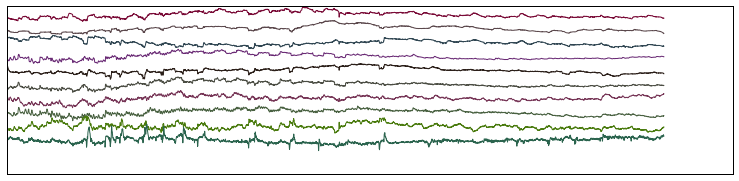

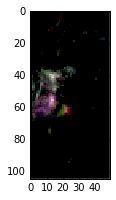

35
91
110
155
168
184
185
198
226
227
230
233
249
252
253
LH


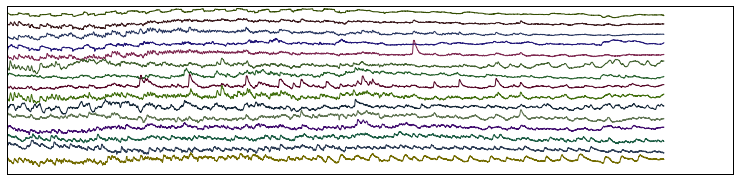

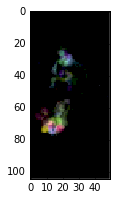

2
15
72
90
113
116
118
123
128
140
144
174
177
187
197
217
231
SNP


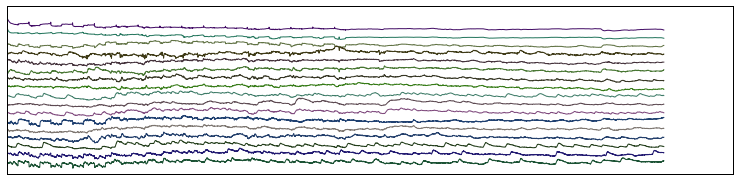

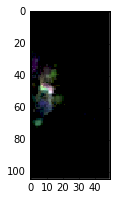

77
85
94
97
105
107
127
134
137
145
146
154
166
189
205
213
225
236
237
254
CX


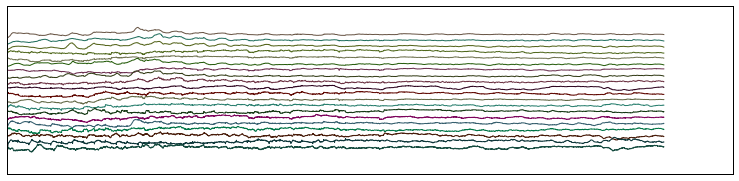

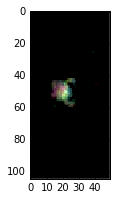

66
70
152
162
240
INP


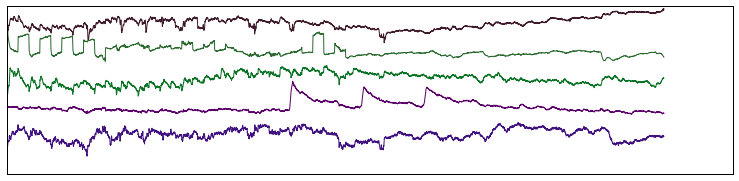

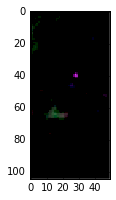

12
23
45
59
62
63
101
238
242
244
PENP


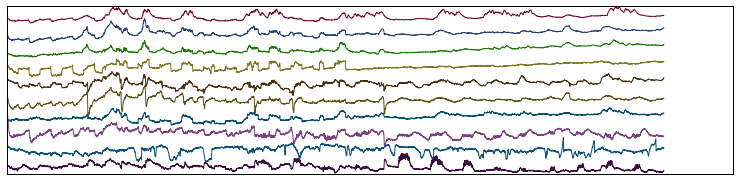

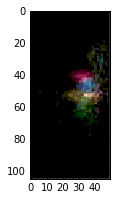

18
20
40
48
132
149
157
181
206
228
248
250
GNG


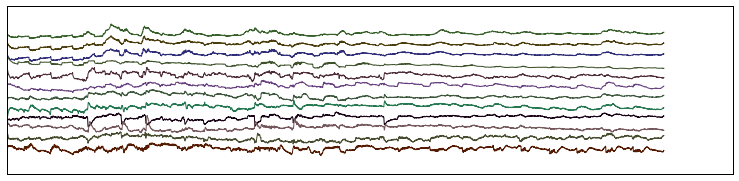

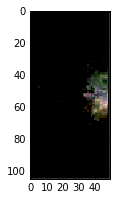

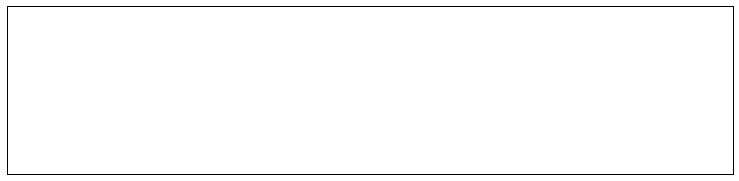

In [37]:
pylab.rcParams['figure.figsize'] = (13, 3)

h=5
tot=0
NumberInLargeRegion=np.zeros(13)

for l in range(12):
    Final_maps=np.zeros((S[0],S[1],3))
    Fmap=np.zeros((S[0],S[1],3))
    C=np.zeros(3)

    n=0
    for i in range(len(CompMainName)):                    
        Dmmv=np.mean(data[:,:,:,i],2) 
        Dmmv[Dmmv<0.2*np.max(np.max(np.max(Dmmv)))]=0
        C=np.squeeze(np.random.rand(3,1))
        labeled, nrobject=ndimage.label(Dmmv>0)
        
        if CompMainName[i]==Names[l][0] and (sum(CompNameAdd[i,:])<5) and nrobject<200 and GoodICAnat[i]==1:
            n=n+1            
            
            for k in range(3):
                Fmap[:,:,k]=0.7*Dmmv*(C[k]+0.2)/np.max(C+0.2)
            Final_maps=Final_maps+Fmap
            #plt.plot(Time_fluoICA.T,(DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            plt.plot((DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            tot=tot+1
            GoodICAnat[i]=1
            print(i)
                    
    if n!=0:
        print(RegionName[l])
        plt.show()
        FM=Final_maps/np.max(np.max(Final_maps))
        FM[FM<0.1]=0
        plt.imshow(FM,interpolation='none')
        plt.show()
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
                
    NumberInLargeRegion[l]=n
        

In [22]:
BadICs=[]

In [24]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)
Ua=sio.loadmat(filename)
Xk=Ua['Xk']

/media/sophie/008C0665790F0763/ComboPanNeuronalGCaMP6/40x/960/960Xk.mat


In [25]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filenamet = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filenamet)
nimt=nb.load(filenamet)
Dtemp=np.squeeze(nimt.get_data())
Dtemp.shape

/media/sophie/008C0665790F0763/ComboPanNeuronalGCaMP6/40x/960/960registration/AVG_960ss1_500regc.nii


(88, 77, 34)

/usr/local/lib/python2.7/dist-packages/numpy/lib/shape_base.py:422: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))


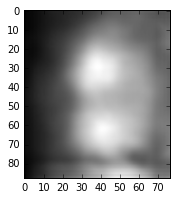

In [26]:
if S[2]>5:
    Nstack=5
    Int100=[(i+1)*100/Nstack for i in range(Nstack)]
    Percs=np.percentile(range(S[2]),Int100)
    Indices=np.split(range(S[2]),Percs)
    D1=np.zeros([S[0],S[1],Nstack])
    Dmean=np.squeeze(data[:,:,range(Nstack),2])
    for i in range(Nstack):
        Vmean=np.mean(Dtemp[:,:,Indices[i]],2)
        Dmean[:,:,i]=Vmean
else:
    Nstack=S[2]
    D1=np.zeros([S[0],S[1],S[2]])
    Dmean=data[:,:,range(S[2])]  
    Dmean=np.squeeze(Dtemp[:,:,:])

for j in range(S[3]):

    a=''
    if S[2]>5:
        for i in range(Nstack):
            V=Dmaps[:,:,Indices[i],j]
            D1[:,:,i]=np.max(V,2)
        D2[:,:,:,j]=D1
        D1[D1==0]=np.nan

plt.imshow(Dmean[:,:,1],cmap=plt.cm.gray)

In [27]:
from sklearn import linear_model

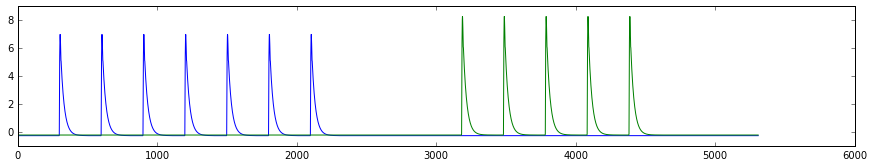

In [28]:
my_cmap=plt.cm.jet
my_cmap.set_bad(alpha=0)
Good_ICs=np.zeros(S[3])
Label_ICs=[]
pylab.rcParams['figure.figsize'] = (15, 2.5)

algorithm = linear_model.LinearRegression()

Sxk=Xk.shape

Sxk

X=np.zeros((Sxk[0],2))

X[:,0]=(Xk[:,0]-np.mean(Xk[:,0]))/np.std(Xk[:,0])
X[:,1]=(Xk[:,1]-np.mean(Xk[:,1]))/np.std(Xk[:,1])
#X[:,2]=(Xk[:,3]-np.mean(Xk[:,3]))/np.std(Xk[:,3])
#X[:,3]=(Xk[:,4]-np.mean(Xk[:,4]))/np.std(Xk[:,4])
#X[:,4]=(Xk[:,6]-np.mean(Xk[:,6]))/np.std(Xk[:,6])
#X[:,5]=(Xk[:,7]-np.mean(Xk[:,7]))/np.std(Xk[:,7])

plt.plot(X[:,0])
plt.plot(X[:,1])

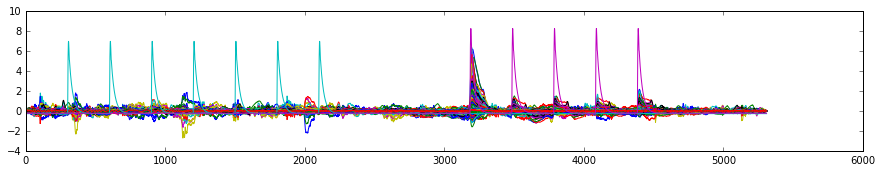

In [29]:
Rsq=np.zeros((1,S[3]))
Betas=np.zeros((2,S[3]))

X.shape

DT.shape

for j in range(S[3]):
    model = algorithm.fit(X, DT[:,j])
    Betas[:,j] = model.coef_
    Rsq[:,j] = model.score(X,DT[:,j])

plt.plot(DT)
plt.plot(X)

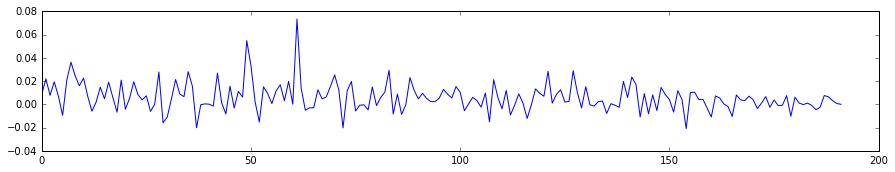

In [30]:
RsqUni=np.zeros((6,S[3]))
BetaUni=np.zeros((6,S[3]))

Sx=X.shape

for k in range(2):
    for j in range(S[3]):
        model = algorithm.fit(np.reshape(X[:,k],(Sx[0],1)), DT[:,j])
        BetaUni[k,j] = model.coef_
        RsqUni[k,j] = model.score(np.reshape(X[:,k],(Sx[0],1)),DT[:,j])
    

plt.plot(Betas[0,:])

In [31]:
import random

In [32]:
if S[2]>5:
    Final_map=np.zeros([S[0],S[1],5,3])
    Fmaps=np.zeros([S[0],S[1],5,3])
else:
    Final_map=np.zeros([S[0],S[1],3]) 
    Fmaps=np.zeros([S[0],S[1],3])    
C=np.zeros([S[3],3])
C1=np.zeros([6,3])
C1[0][:]=(1,0,0)
C1[1][:]=(0,1,0)
C1[2][:]=(0,0,1)
C1[3][:]=(0.8,0.8,0)
C1[4][:]=(0,1,1)
C1[5][:]=(1,0,1)
S1=DT.shape

In [33]:
C=np.zeros((S[3],3))
i=0
l=0
Betas2=Betas
LightNuminRegion=np.zeros(12)
for j in range(S[3]):  
    if Betas2[0,j]>0.1*np.max(Betas2[0,:]) and abs(Betas2[1,j])<0.1*np.max(Betas2[1,:]):
    #if 1>0.1:
        #C[j,:]=C1[i%6][:]
        C[j,2]=1
        C[j,1]=Betas2[0,j]/np.max(Betas2[0,:])
        #C[j,2]=1
        for k in range(3):           
            M=np.max(np.squeeze(np.reshape(D2[:,:,:,j],S[0]*S[1]*5)))
            Fmaps[:,:,:,k]=0.25*D2[:,:,:,j]*C[j,k]/M
        Final_map=Final_map+Fmaps
        #Betas[0,j]=0
        #print(Indexo[j])
        print(j+1)
        print(RegionName[int(CompMainName[j])-1])     
        LightNuminRegion[int(CompMainName[j])-1]=LightNuminRegion[int(CompMainName[j])-1]+1
        i=i+1
        l=l+1

        #if l==2:
            #break
    

23
CX
24
VLNP
58
MB
62
VMNP
70
MB
71
VMNP
86
CX
89
VMNP
92
CX
97
MB
109
GNG
112
CX
115
SNP
119
INP
120
CX
122
VMNP
125
VMNP
128
PENP
129
SNP
131
INP
140
SNP
142
VMNP
143
SNP
145
CX
147
SNP
149
GNG
150
CX
153
PENP
156
VLNP
157
INP
167
MB
179
VMNP
188
CX


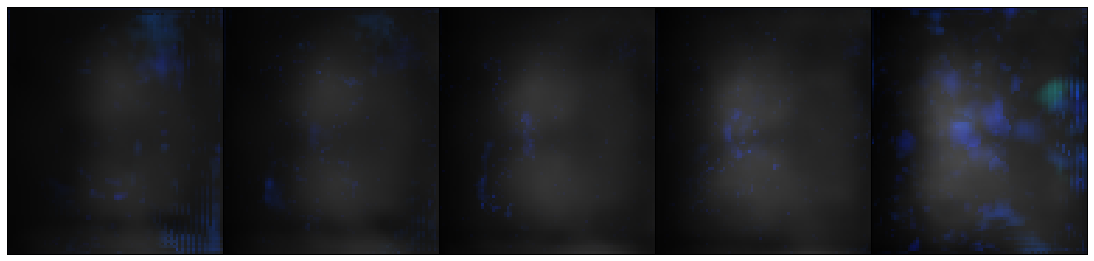

In [34]:
pylab.rcParams['figure.figsize'] = (15, 6)
C2=np.zeros(3)

Df=np.zeros([S[0],S[1],5,3]) 
  
for i in range(3):
    Df[:,:,:,i]=Final_map[:,:,:,i]+Dmean/10
    #Df=Df/(np.max(np.max(np.max(Df),3)))
if S[2]>5:
    N=Nstack
else:
    N=S[2]
for i in range(N):
    #if Good_ICs[j]:
        plt.subplot(1,N,i+1)
        plt.imshow(Df[:,:,i],cmap=plt.cm.gray)
        plt.imshow(Df[:,:,i,:],cmap=my_cmap,interpolation='none')
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
plt.tight_layout(pad=0,w_pad=0,h_pad=0)

In [35]:
C=np.zeros((S[3],3))
i=0
l=0
Betas2=Betas
OdorNuminRegion=np.zeros(12)

for j in range(S[3]):  
    if Betas2[1,j]>0.1*np.max(Betas2[1,:]) and abs(Betas2[0,j])<0.1*np.max(Betas2[0,:]):
    #if 1>0.1:
        #C[j,:]=C1[i%6][:]
        C[j,0]=1
        C[j,1]=Betas2[1,j]/np.max(Betas2[1,:])
        #C[j,2]=1
        for k in range(3):           
            M=np.max(np.squeeze(np.reshape(D2[:,:,:,j],S[0]*S[1]*5)))
            Fmaps[:,:,:,k]=0.25*D2[:,:,:,j]*C[j,k]/M
        Final_map=Final_map+Fmaps
        #Betas2[1,j]=0
        #print(Indexo[j])
        OdorNuminRegion[int(CompMainName[j])-1]=OdorNuminRegion[int(CompMainName[j])-1]+1
        print(RegionName[int(CompMainName[j])-1])
        i=i+1
        l=l+1
        print(j+1)
        #if l==2:
         #   break

NumOdor=i
print('Number of odor components')
print(i)

AL
5
MB
12
MB
13
AL
14
AL
16
AL
18
GNG
19
AL
21
SNP
22
AL
25
AL
26
AL
28
MB
32
SNP
35
MB
39
SNP
40
SNP
41
MB
42
AL
44
AL
47
MB
49
AL
52
AL
56
AL
61
AL
64
AL
66
INP
68
AL
69
AL
76
AL
78
AL
79
SNP
94
AL
95
AL
99
SNP
104
SNP
106
CX
121
CX
126
CX
127
AL
134
Number of odor components
40


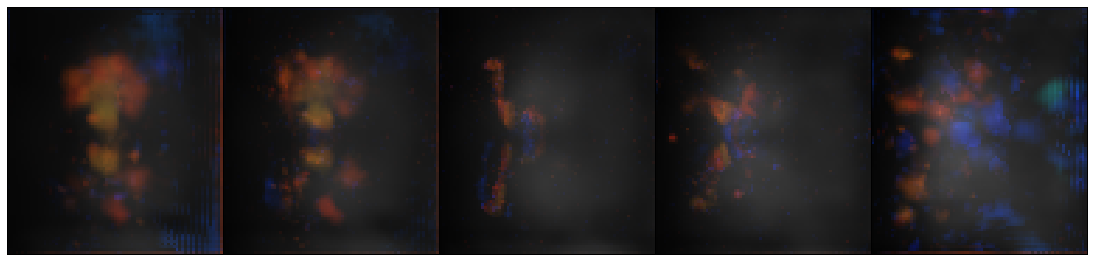

In [36]:
pylab.rcParams['figure.figsize'] = (15, 6)
C2=np.zeros(3)

Df=np.zeros([S[0],S[1],5,3]) 
  
for i in range(3):
    Df[:,:,:,i]=Final_map[:,:,:,i]+Dmean/10
    #Df=Df/(np.max(np.max(np.max(Df),3)))
if S[2]>5:
    N=Nstack
else:
    N=S[2]
for i in range(N):
    #if Good_ICs[j]:
        plt.subplot(1,N,i+1)
        plt.imshow(Df[:,:,i],cmap=plt.cm.gray)
        plt.imshow(Df[:,:,i,:],cmap=my_cmap,interpolation='none')
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
plt.tight_layout(pad=0,w_pad=0,h_pad=0)

In [37]:
np.savetxt('/'.join(filename.split('/')[:-1])+'/OdorNumberInLargeRegions.txt',OdorNuminRegion)
np.savetxt('/'.join(filename.split('/')[:-1])+'/LightNumberInLargeRegions.txt',LightNuminRegion)

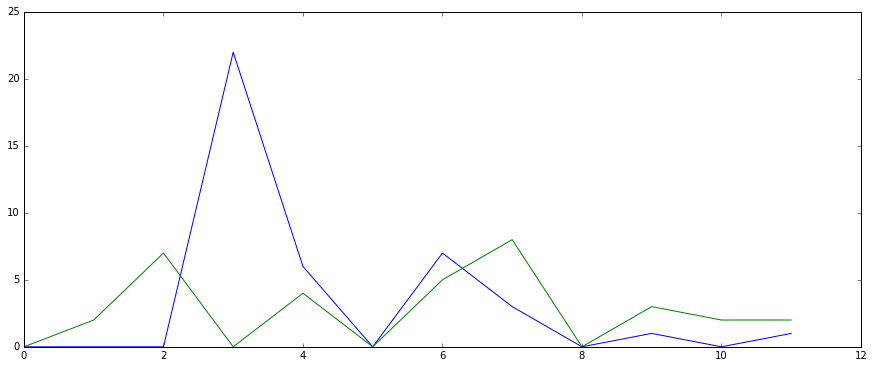

In [38]:
plt.plot(OdorNuminRegion)
plt.plot(LightNuminRegion)